# NSCLC-Radiomics Dataset - Processing Pipeline

* Establishing the number of patients that would match the number of slices removed for the 'Dev split'
* Selecting the random patients for which data quality is high enough and maximize RMSE with the normalized training patients
* Saving the selected patients with the same augmentations as in MSD
* Creating synthetical patients using the Clustering algorithm suggested in `ct_unsupervised_clustering.ipynb`

## Imports

In [89]:
import os
import warnings
warnings.filterwarnings("ignore") # remove some scikit-image warnings


from monai.apps import DecathlonDataset, TciaDataset
from monai.data import DataLoader
from monai.transforms import (
    LoadImageD,LoadImaged,
    EnsureChannelFirstD, EnsureChannelFirstd,
    Compose,
    OrientationD,
    OrientationD,
    Rotate90D, Rotate90,
    ResampleToMatchd
)
from monai.apps.tcia import TCIA_LABEL_DICT

import torch
import numpy as np
import random
import sys
from tqdm import tqdm
import pickle as pkl
import matplotlib.pyplot as plt
import cv2

## Hyperparamaters

In [90]:
crt_dir = os.getcwd()
datasets_path = f'{crt_dir}/datasets/Rad/'

# DOWNLOAD_FLAG = not os.path.exists(datasets_path)
DOWNLOAD_FLAG = False

KEYS = ["image", "seg"]

In [91]:
# from glob import glob
os.path.isdir(datasets_path)

True

## PREPROCESSING TRANSFORMS

In [92]:
# To decode the specific labels we need LoadImage and ResampleToMatchd based on: https://docs.monai.io/en/stable/apps.html
# Not like in MSD, Data comes with patient alligned to the right wall (instead of left), from top of the lungs to the bottom
# We need to rotate on those axis to keep our models alligned with MSD
base_transform = Compose([LoadImaged(reader="PydicomReader", keys=["seg"], 
                                     label_dict=TCIA_LABEL_DICT["NSCLC-Radiomics"]),
                          EnsureChannelFirstd(keys = KEYS),
                          ResampleToMatchd(keys="image", key_dst="seg"),
                          Rotate90D(k=2, spatial_axes=(1, 2), keys = KEYS)
                         ])

In [93]:
# ### TRAINING DATA ###
train_name = 'training' # From Monai: ['training', 'validation', 'test']
# # train_dataset = DecathlonDataset(root_dir = datasets_path,
# #                         task = "Task06_Lung", section = train_name,
# #                         transform = base_transform, download = DOWNLOAD_FLAG)
train_dataset = TciaDataset(root_dir = datasets_path, section = train_name, download = DOWNLOAD_FLAG,
                           collection = "NSCLC-Radiomics", transform = ())

In [94]:
train_dataset[0]

{'image': metatensor([[[-1024., -1024., -1024.,  ..., -1024., -1024., -1024.],
          [-1024., -1024., -1024.,  ..., -1024., -1024., -1024.],
          [-1024., -1024., -1024.,  ..., -1024., -1024., -1024.],
          ...,
          [-1024., -1024., -1024.,  ..., -1024., -1024., -1024.],
          [-1024., -1024., -1024.,  ..., -1024., -1024., -1024.],
          [-1024., -1024., -1024.,  ..., -1024., -1024., -1024.]],
 
         [[-1024., -1024., -1024.,  ..., -1024., -1024., -1024.],
          [-1024., -1024., -1024.,  ..., -1024., -1024., -1024.],
          [-1024., -1024., -1024.,  ..., -1024., -1024., -1024.],
          ...,
          [-1024., -1024., -1024.,  ..., -1024., -1024., -1024.],
          [-1024., -1024., -1024.,  ..., -1024., -1024., -1024.],
          [-1024., -1024., -1024.,  ..., -1024., -1024., -1024.]],
 
         [[-1024., -1024., -1024.,  ..., -1024., -1024., -1024.],
          [-1024., -1024., -1024.,  ..., -1024., -1024., -1024.],
          [-1024., -1024., 

In [95]:
def get_image_and_label(data):
    transformed = base_transform(data)
    transf_label = transformed['seg'].permute(1, 2, 3, 0)
    
    return transformed['image'], transf_label[..., 1].unsqueeze(0)

In [98]:
def estimate_number_of_added_patients(crt_dataset, mean_slices_for_msd = 283, no_of_replaced_msd_patients = 9):
    # no_slices = []

    # for ds_idx in tqdm(range(len(crt_dataset))):
    #     # print(train_dataset[ds_idx]['image'].shape)
    #     # break
    #     no_slices.append(train_dataset[ds_idx]['image'].shape[-1])

    # # print(np.array(no_slices).mean())

    # mean_training_slices = np.array(no_slices).mean()
    mean_training_slices = 120.52522255192878
    truncated_rad_tr_slices = round(mean_training_slices, 0)

    patients_to_add_from_RAD = int(round(no_of_replaced_msd_patients * mean_slices_for_msd / truncated_rad_tr_slices, 0))

    return patients_to_add_from_RAD

In [99]:
replace_patients_rad = estimate_number_of_added_patients(train_dataset, mean_slices_for_msd = 283, no_of_replaced_msd_patients = 9)
replace_patients_rad

21

In [100]:
from eda_src.normalization import min_max_normalization
from eda_src.random_sample_funcs import rmse_dev_vs_val
from eda_src.clustering_funcs import apply_kmeans

In [101]:
computational_effort_train_path = f'./msd_eda1_computational_effort_training.pkl'

binning_volume_tr, _, bins_2d_tr, _, _, _ = pkl.load(open(computational_effort_train_path, 'rb'))
normalized_bins_tr = min_max_normalization(np.sum(bins_2d_tr, axis = 0))

In [102]:
def pick_best_samples(target_bins, no_tries, no_samples = 9, set_idx = None):
    max_rmse = 0
    best_heatmap, best_idx = None, None
    
    for crt_try in range(no_tries):
        print(f'Try {crt_try + 1}/{no_tries}')
        rand_idx = random.sample(range(len(train_dataset)), no_samples)

        if set_idx is not None:
            rand_idx = set_idx


        dev_heatmap = np.zeros((512, 512))

        for count, ds_idx in enumerate(rand_idx):
            print(f'Adding patient: {count + 1}/{no_samples}')
            _, label = get_image_and_label(train_dataset[ds_idx])
            dev_heatmap += label.squeeze().sum(axis=2).numpy()
            
        print(f'Heatmap shape: {dev_heatmap.shape}')
        normalised_dev_heatmap = min_max_normalization(dev_heatmap)

        rmse = rmse_dev_vs_val(normalised_dev_heatmap, target_bins)
        
        print(f'For current indices: {rand_idx}\nRMSE  = {rmse:.3f}')
        
        if rmse > max_rmse:
            max_rmse = rmse
            best_heatmap = dev_heatmap
            best_idx = rand_idx

        if set_idx is not None:
            break
    
    return best_heatmap, best_idx, max_rmse

In [167]:
best_indices = [271, 114, 97, 33, 240, 168, 214, 164, 302, 12, 35, 225, 105, 88, 71, 106, 197, 40, 167, 44, 300] 
low_quality_indices = [16, 42, 48, 121, 221]


best_indices = list(set(best_indices) - set(low_quality_indices))
best_indices

[12,
 271,
 33,
 35,
 164,
 167,
 168,
 40,
 44,
 300,
 302,
 197,
 71,
 214,
 88,
 97,
 225,
 105,
 106,
 240,
 114]

In [152]:
variants = [68, 24, 179, 42, 37, 317, 25, 58, 208, 244, 31, 328, 309, 266, 71, 313, 146, 216, 155, 14, 242] + [133, 88, 22, 246, 146, 221, 236, 307, 168, 165, 116, 44, 209, 94, 40, 333, 298, 245, 167, 144, 300]


other_possible_indices = list(set(variants) - set(best_indices) - set(low_quality_indices))

print(other_possible_indices)

[133, 266, 14, 144, 146, 22, 24, 25, 155, 31, 37, 165, 42, 298, 179, 307, 309, 313, 58, 317, 68, 328, 333, 208, 209, 216, 221, 94, 236, 242, 244, 116, 246, 245]


In [199]:
add_var = [167, 40, 44, 300]

best_heatmap, best_idx, max_rmse = pick_best_samples(normalized_bins_tr, 5, no_samples=replace_patients_rad, set_idx=best_indices)

Try 1/5
Adding patient: 1/21
Adding patient: 2/21
Adding patient: 3/21
Adding patient: 4/21
Adding patient: 5/21
Adding patient: 6/21
Adding patient: 7/21
Adding patient: 8/21
Adding patient: 9/21
Adding patient: 10/21
Adding patient: 11/21
Adding patient: 12/21
Adding patient: 13/21
Adding patient: 14/21
Adding patient: 15/21
Adding patient: 16/21
Adding patient: 17/21
Adding patient: 18/21
Adding patient: 19/21
Adding patient: 20/21
Adding patient: 21/21
Heatmap shape: (512, 512)
For current indices: [12, 271, 33, 35, 164, 167, 168, 40, 44, 300, 302, 197, 71, 214, 88, 97, 225, 105, 106, 240, 114]
RMSE  = 0.047


In [196]:
print(f'Indices: {best_idx}\nRMSE: {max_rmse:.3f}')

Indices: [271, 114, 121, 97, 33, 240, 168, 214, 164, 302, 12, 35, 225, 105, 221, 48, 88, 16, 71, 106, 197]
RMSE: 0.050


In [ ]:
# For current indices: [68, 24, 179, 42, 37, 317, 25, 58, 208, 244, 31, 328, 309, 266, 71, 313, 146, 216, 155, 14, 242]
# RMSE  = 0.043
# For current indices: [133, 88, 22, 246, 146, 221, 236, 307, 168, 165, 116, 44, 209, 94, 40, 333, 298, 245, 167, 144, 300]
# RMSE  = 0.043
# For current indices: [271, 114, 121, 97, 33, 240, 168, 214, 164, 302, 12, 35, 225, 105, 221, 48, 88, 16, 71, 106, 197]
# RMSE  = 0.050

146


In [156]:
remove_bed_bbox_2d = (60, 450, 119, 425)

In [201]:
with open('./msd_eda1_computational_effort_training.pkl', 'rb') as f:
    binning_volume_tr, _, bins_2d_tr, _, _, _ = pkl.load(f)

In [204]:
prev_patients = bins_2d_tr.sum(axis=0)
mitigated_patients = prev_patients + best_heatmap

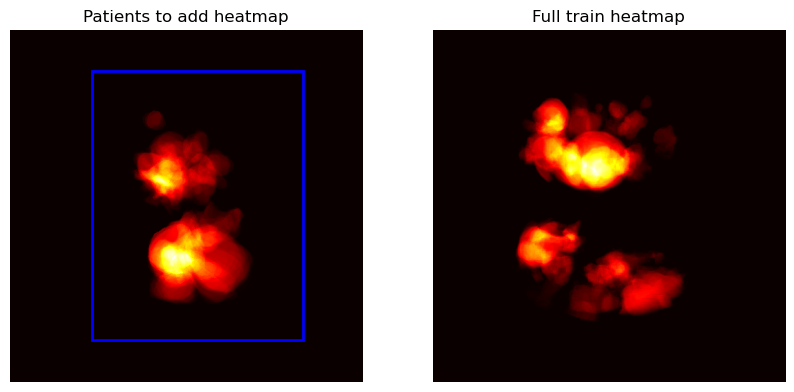

In [200]:
fig, ax = plt.subplots(1, 3, figsize=(10, 5))

if remove_bed_bbox_2d is not None:
    h_min, h_max, w_min, w_max = remove_bed_bbox_2d
    ax[0].add_patch(plt.Rectangle((w_min, h_min), w_max - w_min, h_max - h_min, fill=False, edgecolor='blue', lw=2))

ax[0].imshow(best_heatmap, cmap='hot')


ax[0].axis('off')
ax[0].set_title(f'RMSE: {max_rmse:.3f}')
ax[0].set_title('Patients to add heatmap')
ax[1].imshow(normalized_bins_tr, cmap='hot')
ax[1].axis('off')
ax[1].set_title('Full train heatmap')


plt.show()



In [169]:
from eda_src.normalization import min_max_normalization
from eda_src.pca_funcs import pca_singural_values

In [170]:
# def min_max_normalize(img):
#     no_stacks = img.shape[-1]

#     for i in range(no_stacks):
#         img[:, :, :, i] = (img[:, :, :, i] - img[:, :, :, i].min()) / (img[:, :, :, i].max() - img[:, :, :, i].min())

#     return img

def remove_bed(img, bbox):
    '''
    Remove the bed from the image
    '''

    # print(img.shape)

    min_img = img.min()
    new_img = torch.ones_like(img) * min_img

    new_img[:, bbox[0]:bbox[1], bbox[2]:bbox[3], :] = img[:, bbox[0]:bbox[1], bbox[2]:bbox[3], :]

    return new_img


In [172]:
rad_tr_name = 'rad_tr2_samples'

os.makedirs(f'{datasets_path}/{rad_tr_name}', exist_ok=True)
os.makedirs(f'{datasets_path}/{rad_tr_name}/images', exist_ok=True)
os.makedirs(f'{datasets_path}/{rad_tr_name}/labels', exist_ok=True)

best_index_offset = 42

save_flag = True

for idx in best_indices:
    print(f'Processing patient {idx}')
    image, label = get_image_and_label(train_dataset[idx])
    image = min_max_normalization(image)
    image = remove_bed(image, remove_bed_bbox_2d)
    
    if save_flag:
        torch.save(image, f'{datasets_path}/{rad_tr_name}/images/patient_{best_index_offset}.pt')
        torch.save(label, f'{datasets_path}/{rad_tr_name}/labels/patient_{best_index_offset}.pt')

    best_index_offset += 1


Processing patient 12
Processing patient 271
Processing patient 33
Processing patient 35
Processing patient 164
Processing patient 167
Processing patient 168
Processing patient 40
Processing patient 44
Processing patient 300
Processing patient 302
Processing patient 197
Processing patient 71
Processing patient 214
Processing patient 88
Processing patient 97
Processing patient 225
Processing patient 105
Processing patient 106
Processing patient 240
Processing patient 114


In [194]:
print(f'Best indices: {best_indices}')

Best indices: [12, 271, 33, 35, 164, 167, 168, 40, 44, 300, 302, 197, 71, 214, 88, 97, 225, 105, 106, 240, 114]


In [173]:
from eda_src.random_sample_funcs import get_first_tumorous_slice, get_last_tumorous_slice

In [174]:
def save_images_for_set_indices(set_train_idx : list, dataset, save_path : str):

    os.makedirs(save_path, exist_ok= True)

    for idx in set_train_idx:
        image, label = get_image_and_label(dataset[idx])
        
        print(f'Image shape: {image.shape} Label shape: {label.shape}')

        start = get_first_tumorous_slice(label)
        stop = get_last_tumorous_slice(label)

        print(f'Start: {start} Stop: {stop}')

        for i in range(start, stop):
            fig, ax = plt.subplots(1, 2, figsize=(10, 5))

            ax[0].imshow(image[0, ..., i])
            ax[0].imshow(label[0, ..., i], cmap='gray', alpha=0.5)
            ax[0].axis('off')
            ax[0].set_title(f'Slice {i}')

            ax[1].imshow(label[0, ..., i] > 0,  cmap = 'jet', alpha = 0.95)
            ax[1].axis('off')
            ax[1].set_title(f'Label {i}')


            plt.savefig(f'{save_path}/patient{idx}_slice{i}.png')
            plt.close()

In [175]:
save_flag = True

if save_flag:
    save_images_for_set_indices(best_indices, train_dataset, f'{crt_dir}/plots/RAD_best/images')

Image shape: torch.Size([1, 512, 512, 115]) Label shape: torch.Size([1, 512, 512, 115])
Start: 50 Stop: 58
Image shape: torch.Size([1, 512, 512, 176]) Label shape: torch.Size([1, 512, 512, 176])
Start: 55 Stop: 74
Image shape: torch.Size([1, 512, 512, 131]) Label shape: torch.Size([1, 512, 512, 131])
Start: 42 Stop: 67
Image shape: torch.Size([1, 512, 512, 110]) Label shape: torch.Size([1, 512, 512, 110])
Start: 38 Stop: 48
Image shape: torch.Size([1, 512, 512, 110]) Label shape: torch.Size([1, 512, 512, 110])
Start: 45 Stop: 67
Image shape: torch.Size([1, 512, 512, 134]) Label shape: torch.Size([1, 512, 512, 134])
Start: 36 Stop: 74
Image shape: torch.Size([1, 512, 512, 104]) Label shape: torch.Size([1, 512, 512, 104])
Start: 46 Stop: 55
Image shape: torch.Size([1, 512, 512, 94]) Label shape: torch.Size([1, 512, 512, 94])
Start: 34 Stop: 55
Image shape: torch.Size([1, 512, 512, 97]) Label shape: torch.Size([1, 512, 512, 97])
Start: 32 Stop: 47
Image shape: torch.Size([1, 512, 512, 99]

In [ ]:
# Bad Quality patients: [16, 48, 121, 221]

In [ ]:
# points_indices = {0 : {'patient_id': _, 'slice_id': _} for _ in range(42, 63)}

In [177]:
points_indices = {}

points = []

crt_point = 0

for idx in best_indices:
    print(f'Processing patient {idx}')
    image, label = get_image_and_label(train_dataset[idx])

    no_slices = image.shape[-1]

    for slice_id in range(no_slices):
        print(f'Processing slice {slice_id + 1}/{no_slices}')
        points_indices[crt_point] = {'patient_id': idx, 'slice_id': slice_id}
        crt_point += 1

        crt_point_coords = pca_singural_values(image[0, ..., slice_id].numpy(), taken_components=150)
        points.append(crt_point_coords)


Processing patient 12
Processing slice 1/115
Processing slice 2/115
Processing slice 3/115
Processing slice 4/115
Processing slice 5/115
Processing slice 6/115
Processing slice 7/115
Processing slice 8/115
Processing slice 9/115
Processing slice 10/115
Processing slice 11/115
Processing slice 12/115
Processing slice 13/115
Processing slice 14/115
Processing slice 15/115
Processing slice 16/115
Processing slice 17/115
Processing slice 18/115
Processing slice 19/115
Processing slice 20/115
Processing slice 21/115
Processing slice 22/115
Processing slice 23/115
Processing slice 24/115
Processing slice 25/115
Processing slice 26/115
Processing slice 27/115
Processing slice 28/115
Processing slice 29/115
Processing slice 30/115
Processing slice 31/115
Processing slice 32/115
Processing slice 33/115
Processing slice 34/115
Processing slice 35/115
Processing slice 36/115
Processing slice 37/115
Processing slice 38/115
Processing slice 39/115
Processing slice 40/115
Processing slice 41/115
Pro

In [180]:
points_np = np.array(points)
points_np.shape

(2468, 150)

In [182]:
from sklearn.cluster import KMeans

NO_CLUSTERS = 5

kmeans = KMeans(n_clusters=NO_CLUSTERS, random_state=0).fit(points_np)

In [186]:
for i in range(NO_CLUSTERS):
    label_indices = np.nonzero(kmeans.labels_ == i)

    print(f'Cluster {i} has {len(label_indices[0])} points')

Cluster 0 has 707 points
Cluster 1 has 527 points
Cluster 2 has 379 points
Cluster 3 has 497 points
Cluster 4 has 358 points


In [189]:
def plot_clusters(components_patient_info, NO_CLUSTERS, NO_IMAGES = 6):
    fig, axes = plt.subplots(NO_CLUSTERS, NO_IMAGES, figsize=[20, 5])

    for i in range(NO_CLUSTERS):
        label_indices = np.nonzero(kmeans.labels_ == i)

        # Randomly select NO_IMAGES images from the cluster
        random_indices = random.sample(list(label_indices[0]), NO_IMAGES)

        # Put the title to the left
        axes[i, 0].yaxis.set_label_position("left")
        axes[i, 0].set_ylabel(f'Cluster {i}')


        for j, idx in enumerate(random_indices):
            metadata = components_patient_info[idx]
            patient_id, slice_idx = metadata['patient_id'], metadata['slice_id']

            patient_volume, _ = get_image_and_label(train_dataset[patient_id])

            img = patient_volume[0, ..., slice_idx]
            axes[i, j].imshow(img, cmap='gray')
            # axes[i, j].set_title(f'Cluster {i} - Image {j}')
            axes[i, j].set_axis_off()
        
    plt.tight_layout()
    plt.show()

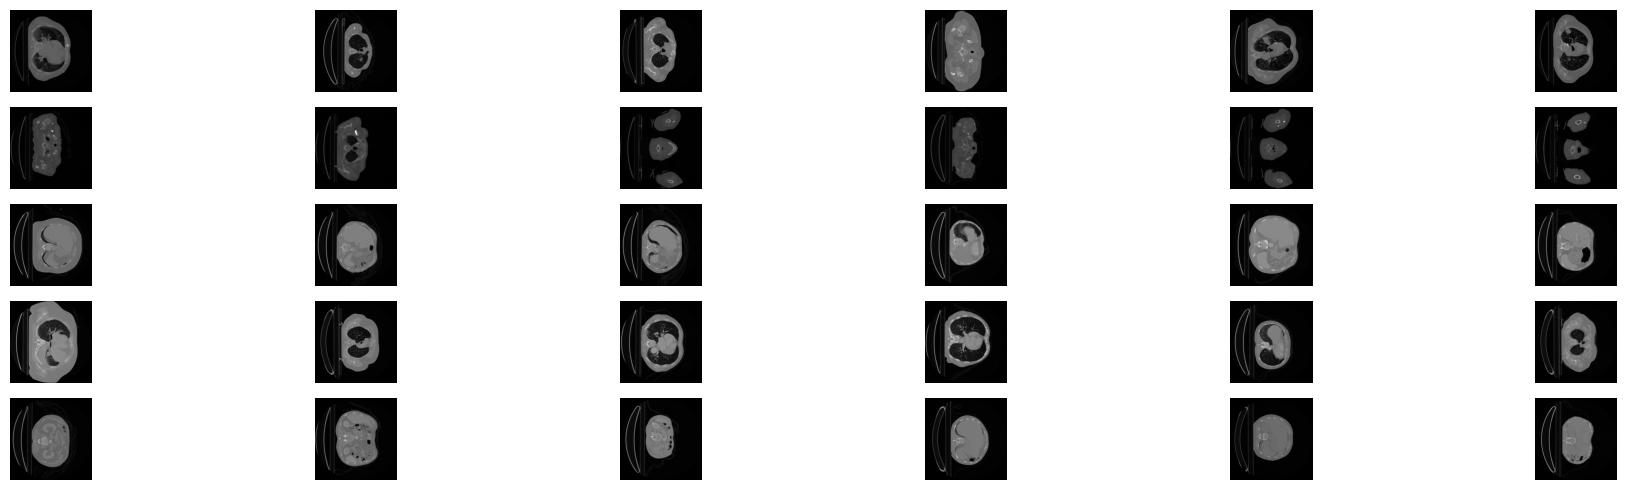

In [190]:
plot_clusters(points_indices, NO_CLUSTERS)

In [ ]:
# TODO: Future work

best_index_offset = 42

for _ in best_indices:
    image, label = torch.zeros((1, 512, 512, 120)), torch.zeros((1, 512, 512, 121))

    crt_slice_idx = 0

    slices_to_take_from_cluster = image.shape[-1] // NO_CLUSTERS

    #TODO: Ordonat de mana clusterele cand fac asta
    for cluster_id in range(NO_CLUSTERS):
        label_indices = np.nonzero(kmeans.labels_ == cluster_id)
        print(label_indices)

        chosen_labels = random.sample(list(label_indices), slices_to_take_from_cluster)

        for label_idx in chosen_labels:
            patient_id, slice_id = points_indices[label_idx]['patient_id'], points_indices[label_idx]['slice_id']

            slice_origin_image, slice_origin_label = get_image_and_label(train_dataset[patient_id])

            image[..., crt_slice_idx] = slice_origin_image[..., slice_id]
            label[..., crt_slice_idx] = slice_origin_label[..., slice_id]
            crt_slice_idx += 1

    image = min_max_normalization(image)
    image = remove_bed(image, remove_bed_bbox_2d)
    
    plt.imshow(image[0, ..., 60], cmap='gray')
    break
    
    # if save_flag:
    #     torch.save(image, f'{datasets_path}/rad_synthetical_samples/images/patient_{best_index_offset}.pt')
    #     torch.save(label, f'{datasets_path}/rad_synthetical_samples/labels/patient_{best_index_offset}.pt')

    # best_index_offset += 1

